# Atividade 2.1 - Treinamento de um neurônio Perceptron

Nesta atividade, realizaremos o treinamento de um neurônio perceptron considerando 3 cenários:
* Na resolução de problemas linearmente separáveis (etapa 1);
* Na exploração de novos dados separados para o time (etapa 2);
* Na tentativa de resolver problemas que não são linearmente separáveis (etapa 3).

Além disso, para a realização destas 3 etapas, considera-se necessário a inclusão de uma etapa 0 para desenvolvimento do código-fonte **base** para as demais etapas.

> **Time**
* Diana Martins - 2115310033
* Gabriel Dos Santos Lima- 2115310010
* Thiago Marques - 2115310024
* Debora Souza Barros - 2115310058

## Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np # biblioteca obrigatória!
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score # utilizar para importação de métricas
from os import path
from collections.abc import Callable

## Etapa 0: Criação de um neurônio e métodos úteis para realização de seu treinamento

### Componentes de um neurônio Perceptron
* Entradas (vetor de valores numéricos);
* Pesos (vetor de pesos correspondente a cada entrada e o viés);
* Viés (com valor -1, que irá está junto com as entradas);
* Função de ativação (para este projeto, será utilizada a função degrau):
\begin{align}
  f(u) =
    \begin{cases}
      1&\text{, u ≥ θ (limiar de ativação)}\\
      0&\text{, c.c.}
    \end{cases}
\end{align}
* Saída.

Além dos componentes base, precisamos de alguma medida para saber se o neurônio está melhorando. Podemos medir o erro:

\begin{align}
  e = y_d(x) - y(x)
\end{align}

> Sendo:
* $e$ o erro. Considerando a função de ativação **degrau**, os valores de $e$ podem ser 0, 1, e -1;
* $y_d$ a saída esperada;  
* $y$ a saída recebida;   
* $x$ a entrada.

Podemos então ajustar o t-ésimo vetor de pesos, calculando:

\begin{align}
  w(t+1) = w(t) +\underbrace{Δw(t)}_\text{Regra delta }
\end{align}

A regra delta é expressa na forma:

\begin{align}
  Δw(t) = η * e * x(i)
\end{align}

> Sendo:
* $x(i)$ a entrada que causou o erro;
* $e$ o erro;
* $\eta$ o coeficiente de aprendizado (para este projeto terá valor **0.1**)

### Treinamento do Neurônio
Antes de iniciar o treinamento, podemos definir 3 classes principais que utilizaremos durante as etapas posteriores, sendo elas:
* **Logger** - imprime os _logs_ das etapas que vão sendo concluídas durante a execução do código;
* **PerceptronNeuron** - classe principal com o código de inicialização, treinamento e predição do neurônio Perceptron;
* **Plotting** - classe para apresentação de gráficos.

In [ ]:
class Logger():
  def __init__(self, silence = False):
    self.__content: list[str] = []
    self.silence = silence

  def add(self, output: str):
    if self.silence: return
    self.__content.append(output)

  def show(self):
    if self.silence: return
    for info in self.__content:
      print(info)

In [ ]:
class PerceptronNeuron():
  def __init__(self,
               learning: int,
               x: np.ndarray,
               y: np.ndarray,
               activation_fn: Callable[[float], int],
               w_initial_range = (-0.5, 0.5),
               w_initial: np.ndarray = None,
               epochs = None,
               logger = Logger(True)):
    self.learning = learning
    self.x = x
    self.y = y
    self.activation_fn = activation_fn
    self.epochs = epochs
    self.logger = logger
    self.fit_epochs_count = None
    self.fit_weight_adjusts = None

    self.w = w_initial if w_initial != None else self.__init_weights(w_initial_range)
    self.logger.add(f"[Initializing] Initial weights (w): {self.w}" )

  def __init_weights(self, w_initial_range: tuple[float, float]) -> np.ndarray:
    w_min, w_max = w_initial_range
    self.logger.add(f"[Initializing] Initial weights with values between [{w_min}, {w_max}]")
    w_length = self.x.shape[1] + 1
    self.logger.add(f"[Initializing] Number of Weights: {w_length}")
    return np.random.random(w_length) * (w_max-w_min) + w_min

  # Calcula o potencial de ativação (u) e aplica a função de ativação para checar o erro (valor real - valor previsto)
  def __calculate_error(self, x_index: int) -> int:

    # Considera-se também o viés na soma do potencial de ativação
    u = -1 * self.w[0]
    x = self.x[x_index]

    # Cálculo do potencial de ativação
    for i in range(len(x)):
      w = self.w[i + 1]
      u += w * self.x[x_index][i]

    # Aplicação da função de ativação
    y = self.activation_fn(u)

    # Cálculo do erro
    yd = self.y[x_index]
    e = yd - y
    return e

  def __needs_fit(self) -> bool:
    for i in range(len(self.x)):
      if self.__calculate_error(i) != 0: return True
    return False

  def __adjust_weights(self, error: int, x_index: int):
    x = self.x[x_index]
    # Regra delta na prática!
    self.w = self.w + self.learning * error * np.concatenate([[-1], x])


  def fit(self, verbose = False, shuffle=False):
    # Verificamos se o neurônio precisa de treinamento
    if not self.__needs_fit():
      if verbose: self.logger.show()
      print(f"Neuron does not need to fit.")
      print(f"Done.")
      return

    epoch = 1
    adjusts = 0
    has_error = True

    # Realizamos o treinamento até não haver erros, e (quando houver um limite de épocas) que esteja dentro da quantidade de épocas permitida.
    while (self.epochs == None and has_error) or (self.epochs != None and epoch <= self.epochs and has_error):
      current_adjusts = 0
      has_error = False

      # Embaralha os elementos de treinamento caso 'shuffle' seja verdadeiro
      if shuffle:
        index_permutation = np.random.permutation(len(self.x))
        self.x = self.x[index_permutation]
        self.y = self.y[index_permutation]

      # Para toda entrada verificamos se ainda há erro.
      # Caso contrário, ajustamos novamente os pesos com base na regra delta (explicado anteriormente no início da etapa 0).
      for i in range(len(self.x)):
        e = self.__calculate_error(i)
        if e != 0:
          self.__adjust_weights(e, i)
          current_adjusts += 1
          has_error = True
      self.logger.add(f"[EPOCH {epoch}] Weights = {self.w} | Total of epoch's weight adjusts = {current_adjusts}")
      epoch += 1
      adjusts += current_adjusts

    epoch -= 1
    self.fit_epochs_count = epoch
    self.fit_weight_adjusts = adjusts
    self.logger.add(f"Total of Epochs: {epoch}")
    self.logger.add(f"Total of Weight Adjusts: {adjusts}")
    self.logger.add("Done.")
    if verbose: self.logger.show()

  # retornar os pesos
  def weights(self):
    return self.w

  # Com os pesos ajustados, podemos utilizar o neurônio para prever novos valores.
  def predict(self, x: np.ndarray):
      y_list = []
      for item in x:
        u = -1 * self.w[0]
        for i in range(len(item)):
          w = self.w[i + 1]
          u += w * item[i]
        y_list.append(self.activation_fn(u))
      return y_list

In [ ]:
class Plotting():
  def plot_one(self, plt, figsize, weights, x, y, title):
    plt.figure(figsize=figsize)
    self.plot_graphic(plt, weights, x, y, title)
    plt.show()

  def plot_various(self, plt, figsize, fig_lines, fig_columns, weights_list, x, y, subplot_titles, suptitle):
    plt.figure(figsize=(figsize))
    plt.suptitle(suptitle, fontsize = 20)
    if(len(x) != (fig_lines * fig_columns)):
      for current_figure in range(fig_lines * fig_columns):
        plt.subplot(fig_lines, fig_columns, current_figure + 1)
        self.plot_graphic(plt, weights_list[current_figure], x, y, subplot_titles[current_figure])
    else:
      for current_figure in range(fig_lines * fig_columns):
        plt.subplot(fig_lines, fig_columns, current_figure + 1)
        self.plot_graphic(plt, weights_list[current_figure], x[current_figure], y[current_figure], subplot_titles[current_figure])
    plt.show()

  def plot_graphic(self, plt, weights, x, y, title):

    # plotando os dados
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=80)

    # plotando a reta de separação
    if weights is not None:
      x1 = np.array([np.min(x[:, 0]), np.max(x[:, 0])])
      x2 = (weights[0] / weights[2]) - (weights[1] / weights[2]) * x1
      plt.plot(x1, x2, color='black', linewidth=5)

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)

In [ ]:
plot = Plotting()

Conforme dito anteriormente, utilizaremos a função de ativação degrau, conforme implementação a seguir

In [ ]:

def heavyside_limiter(value: float, limiar: float) -> int:
    return 1 if value >= limiar else 0

#### Treinando um exemplo de teste
Conjunto de treinamento:
\begin{align}
Γ = \left\{
  \left( \begin{bmatrix}2 \\ 2\end{bmatrix},
  1
  \right),
  \left( \begin{bmatrix}4 \\ 4\end{bmatrix},
  0
  \right)
\right\}
\end{align}

Objetivo: treinar um neurônio que, dado um conjunto de entradas X, consiga corretamente acertar a saída correta.

In [ ]:
x = np.array([[2,2], [4,4]])
y = np.array([1,0])
learning = 0.1
limiar = 0
neuron = PerceptronNeuron(learning, x, y, lambda value: heavyside_limiter(value, limiar), logger=Logger())
neuron.fit(verbose=True)

[Initializing] Initial weights with values between [-0.5, 0.5]
[Initializing] Number of Weights: 3
[Initializing] Initial weights (w): [ 0.49964801  0.2826027  -0.1669655 ]
[EPOCH 1] Weights = [ 0.49964801  0.0826027  -0.3669655 ] | Total of epoch's weight adjusts = 2
[EPOCH 2] Weights = [ 0.49964801 -0.1173973  -0.5669655 ] | Total of epoch's weight adjusts = 2
[EPOCH 3] Weights = [ 0.39964801  0.0826027  -0.3669655 ] | Total of epoch's weight adjusts = 1
[EPOCH 4] Weights = [ 0.39964801 -0.1173973  -0.5669655 ] | Total of epoch's weight adjusts = 2
[EPOCH 5] Weights = [ 0.29964801  0.0826027  -0.3669655 ] | Total of epoch's weight adjusts = 1
[EPOCH 6] Weights = [ 0.29964801 -0.1173973  -0.5669655 ] | Total of epoch's weight adjusts = 2
[EPOCH 7] Weights = [ 0.19964801  0.0826027  -0.3669655 ] | Total of epoch's weight adjusts = 1
[EPOCH 8] Weights = [ 0.19964801 -0.1173973  -0.5669655 ] | Total of epoch's weight adjusts = 2
[EPOCH 9] Weights = [ 0.09964801  0.0826027  -0.3669655 ] |

In [ ]:
x_test = np.array([[2,2]])
y_pred = neuron.predict(x_test)
print(y_pred) # Saída esperada: 1

[1]


In [ ]:
x_test = np.array([[4,4]])
y_pred = neuron.predict(x_test)
print(y_pred) # Saída esperada: 0

[0]


## Etapa 1: Resolvendo um Problema Linearmente Separável

In [ ]:
# carregando os dados
data = np.fromfile('dataAll.txt')

# redefinindo as colunas
data = data.reshape(-1, 3)
data

array([[-363.7884,  244.1423,    0.    ],
       [ 328.7572, -256.7658,    1.    ],
       [-164.9827,  613.2164,    0.    ],
       ...,
       [ 872.4311,  669.1192,    1.    ],
       [ 822.6894, -702.6489,    1.    ],
       [-140.147 ,  734.0983,    0.    ]])

In [ ]:
x = data[:, :2]
y = data[:, 2]
learning = 0.1
limiar = 0
neuron = PerceptronNeuron(learning, x, y, lambda value: heavyside_limiter(value, limiar), logger=Logger())
neuron.fit(verbose=True)

[Initializing] Initial weights with values between [-0.5, 0.5]
[Initializing] Number of Weights: 3
[Initializing] Initial weights (w): [0.11852532 0.26659756 0.20973795]
[EPOCH 1] Weights = [   0.61852532  342.34093756 -268.05253205] | Total of epoch's weight adjusts = 47
[EPOCH 2] Weights = [   0.71852532  358.12748756 -385.90862205] | Total of epoch's weight adjusts = 23
[EPOCH 3] Weights = [   0.71852532  384.34077756 -450.60918205] | Total of epoch's weight adjusts = 26
[EPOCH 4] Weights = [   0.71852532  450.29248756 -444.08220205] | Total of epoch's weight adjusts = 18
[EPOCH 5] Weights = [   0.91852532  436.22649756 -495.70209205] | Total of epoch's weight adjusts = 14
[EPOCH 6] Weights = [   0.61852532  490.75059756 -487.14708205] | Total of epoch's weight adjusts = 13
[EPOCH 7] Weights = [ 4.18525317e-01  4.91280608e+02 -4.96236872e+02] | Total of epoch's weight adjusts = 6
[EPOCH 8] Weights = [ 1.85253168e-02  5.29107018e+02 -5.31340472e+02] | Total of epoch's weight adjusts 

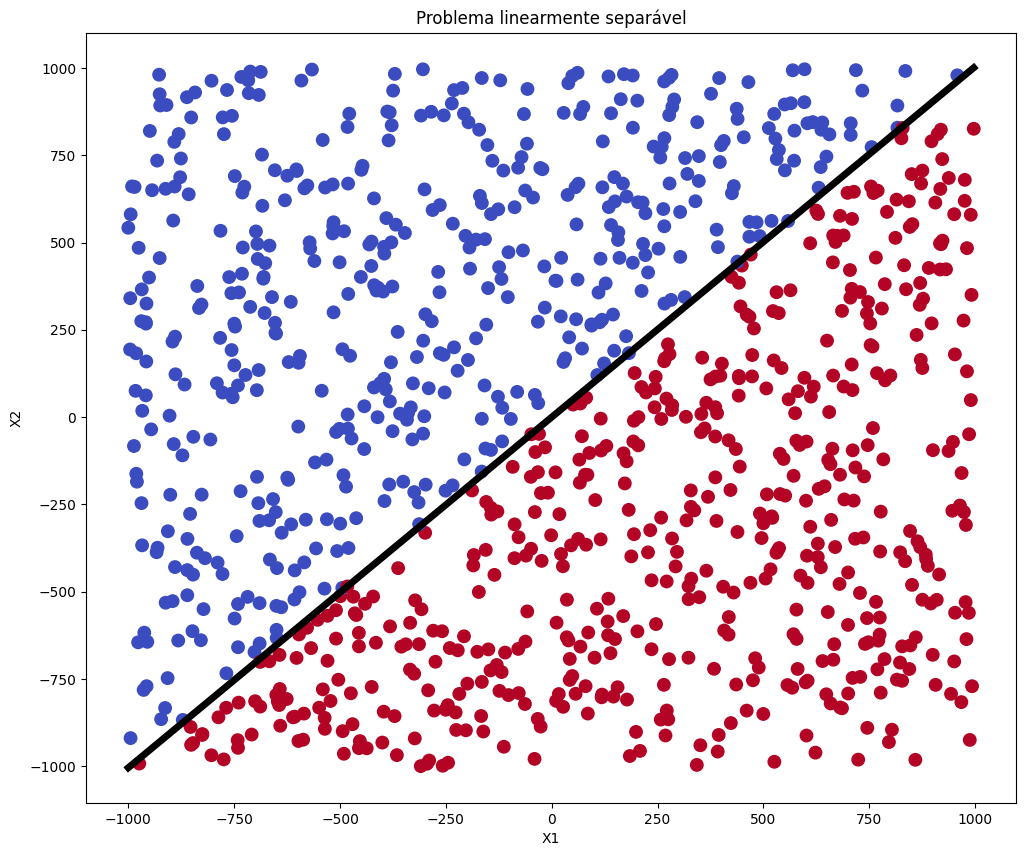

In [ ]:
plot.plot_one(plt, (12, 10), neuron.weights(), x, y, 'Problema linearmente separável')

## Etapa 2: Experimentação

In [ ]:
# Dois últimos dígitos da matrícula de cada aluno
ids = [10, 24, 33, 58]
file_id = 0

for id in ids:
  file_id += id

file_id = file_id % 4
file_name = f"data{file_id}.txt"
file_directory = path.join('.', file_name)

print(file_directory)

./data1.txt


In [ ]:
data2 = np.fromfile(file_directory)

# redefinindo as colunas
data2 = data2.reshape(-1, 3)
data2

array([[ 0.13658687, -0.16460088,  0.        ],
       [-0.0228559 , -0.01094684,  0.        ],
       [-0.02654897,  0.00582183,  0.        ],
       ...,
       [ 0.99007304,  0.8921047 ,  1.        ],
       [ 0.91691441,  1.15684083,  1.        ],
       [ 0.99252852,  1.06937678,  1.        ]])

In [ ]:
x = data2[:, :2]
y = data2[:, 2]

limiar = 0

weights_list = []
titles_list = []
table_list = [] # dict(learning_rate, w_range, list_of_adjusts_amount, minimum_epochs)

logger = Logger()

for learning_rate in (0.4, 0.1, 0.01):
  for w_range in ((-100, 100), (-0.5, 0.5)):
    neuron = None
    adjusts_list = []
    less_epochs = None

    for rep_index in range(10):
      logger.add(f"Rep nº {rep_index + 1} for: |learning_rate={learning_rate}|w_range={w_range}|")
      neuron = PerceptronNeuron(learning_rate, x, y, lambda value: heavyside_limiter(value, limiar), w_range, logger=logger)
      neuron.fit(verbose=True) # Embaralha o conjunto de treinamento a cada época

      if rep_index == 0 or less_epochs > neuron.fit_epochs_count:
        less_epochs = neuron.fit_epochs_count

      adjusts_list.append(neuron.fit_weight_adjusts)

    table_list.append(dict(learning_rate=learning_rate, w_range=w_range, adjusts_list=adjusts_list, less_epochs=less_epochs))
    weights_list.append(neuron.weights())
    titles_list.append(f"|learning_rate={learning_rate}|w_range={w_range}|")

logger.show()

A saída de streaming foi truncada nas últimas 5000 linhas.
[EPOCH 182] Weights = [7.54878307 3.78339474 5.33634968] | Total of epoch's weight adjusts = 2
[EPOCH 183] Weights = [7.54878307 3.79025596 5.33123179] | Total of epoch's weight adjusts = 2
[EPOCH 184] Weights = [7.54878307 3.79711717 5.3261139 ] | Total of epoch's weight adjusts = 2
[EPOCH 185] Weights = [7.54878307 3.8031539  5.32158018] | Total of epoch's weight adjusts = 2
[EPOCH 186] Weights = [7.54878307 3.80919064 5.31704645] | Total of epoch's weight adjusts = 2
[EPOCH 187] Weights = [7.55878307 3.80725889 5.30398006] | Total of epoch's weight adjusts = 1
[EPOCH 188] Weights = [7.55878307 3.81412011 5.29886218] | Total of epoch's weight adjusts = 2
[EPOCH 189] Weights = [7.55878307 3.82098132 5.29374429] | Total of epoch's weight adjusts = 2
[EPOCH 190] Weights = [7.55878307 3.82784254 5.2886264 ] | Total of epoch's weight adjusts = 2
[EPOCH 191] Weights = [7.55878307 3.83470375 5.28350851] | Total of epoch's weight adj

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



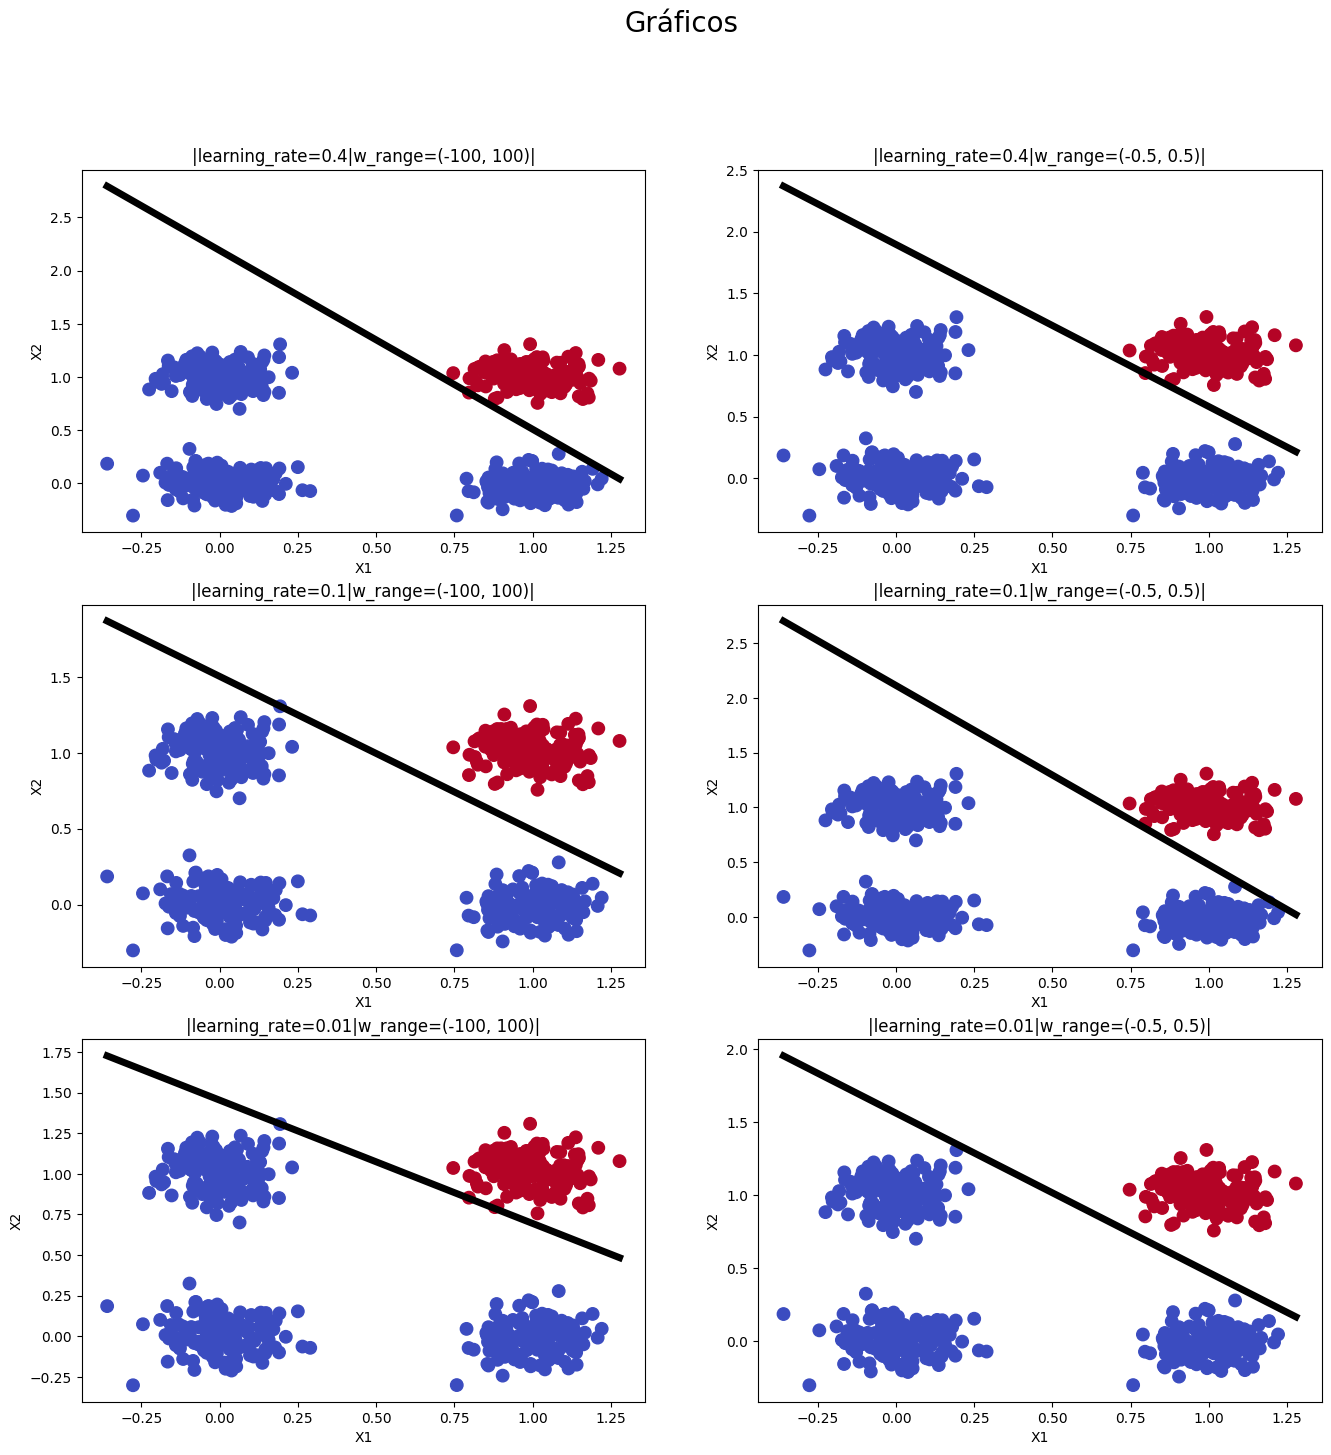

In [ ]:
plot.plot_various(plt, (16, 16), 3, 2, weights_list, x, y, titles_list, "Gráficos")

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Taxa de Aprendizado", "Intervalo de Pesos", "Quantidade de Ajustes", "Menor número de épocas"]

for item in table_list:
  mean = np.mean(item["adjusts_list"])
  desvio_padrao = np.std(item["adjusts_list"])
  table.add_row([item["learning_rate"], item["w_range"], f"{'%.2f'%mean} ± {'%.2f'%desvio_padrao}", item["less_epochs"]])

print(table)

+---------------------+--------------------+-----------------------+------------------------+
| Taxa de Aprendizado | Intervalo de Pesos | Quantidade de Ajustes | Menor número de épocas |
+---------------------+--------------------+-----------------------+------------------------+
|         0.4         |    (-100, 100)     |    315.70 ± 173.71    |           3            |
|         0.4         |    (-0.5, 0.5)     |     35.30 ± 12.70     |           3            |
|         0.1         |    (-100, 100)     |    1504.60 ± 697.42   |           20           |
|         0.1         |    (-0.5, 0.5)     |     32.60 ± 16.09     |           2            |
|         0.01        |    (-100, 100)     |   13013.50 ± 7258.22  |           50           |
|         0.01        |    (-0.5, 0.5)     |     86.90 ± 39.80     |           3            |
+---------------------+--------------------+-----------------------+------------------------+


Podemos verificar que, embora cada configuração dos parâmetros chegue em uma solução para o problema, há combinações de parâmetros que levam menos ajustes e épocas para se chegar em uma solução. E, considerando cenários em que vários desses neurônios são utilizados para resolver um problema, leva vantagem aquela configuração que levou menos tempo em treinamento.

## Etapa 3: Validação Holdout em Problema Não-Linearmente Separável

In [ ]:
data3 = np.fromfile("dataHoldout.txt")

# redefinindo as colunas
data3 = data3.reshape(-1, 3)
data3

array([[-0.29322959, -0.09065359,  1.        ],
       [ 0.07988839,  0.21101297,  1.        ],
       [-0.07825563, -0.08083512,  1.        ],
       ...,
       [ 0.65980493,  1.05876739,  0.        ],
       [ 1.09867123,  0.87404891,  0.        ],
       [ 0.72930655,  0.93224271,  0.        ]])

In [ ]:
def train_test_split(x, y, test_size, shuffle=True):

  if shuffle:
      # Create an array of indices and shuffle it
      indices = np.arange(x.shape[0])
      np.random.shuffle(indices)

      # Apply the indices to shuffle the data
      x = x[indices]
      y = y[indices]

  test_size = int(x.shape[0] * test_size)

  x_train, x_test = x[:-test_size], x[-test_size:]
  y_train, y_test = y[:-test_size], y[-test_size:]

  return x_train, x_test, y_train, y_test

# matriz de confusão
def get_confusion_matrix(y_true, y_pred):
  plt.figure(figsize=(10,8))
  matriz_confusao = confusion_matrix(y_pred, y_true)
  plt.title('Matriz de confusão')
  sns.heatmap(matriz_confusao, annot=True, fmt='.0f', cmap='Blues')
  plt.show()

# avaliação do modelo
def get_scores(y_true, y_pred):
  # acurácia
  acuracia = round(accuracy_score(y_true, y_pred)*100, 2)
  print('Acurácia: {}%'.format(acuracia))

  # precisão
  precisao = round(precision_score(y_true, y_pred, average='macro')*100, 2)
  print("Precisão: {}%".format(precisao))

  # revocação
  revocacao = round(recall_score(y_true, y_pred, average='macro')*100, 2)
  print("Revocação: {}%".format(revocacao))

  # F1 score
  f1 = round(f1_score(y_true, y_pred, average='macro')*100, 2)
  print("F1_Score: {}%".format(f1))

In [ ]:
x = data3[:, :2]
y = data3[:, 2]

x_train, x_test, y_train, y_test = train_test_split(x, y, 0.3)

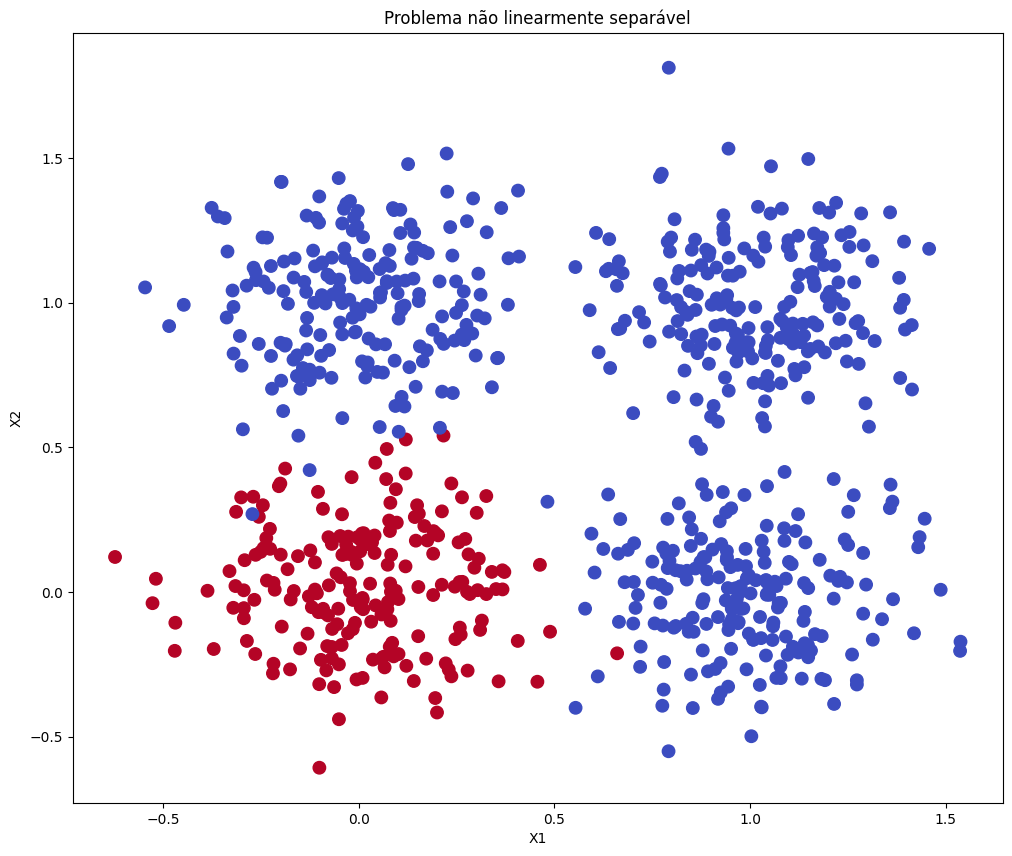

In [ ]:
plot.plot_one(plt, (12, 10), None, x, y, 'Problema não linearmente separável')

In [ ]:
learning = 0.1
limiar = 0
neuron = PerceptronNeuron(learning, x_train, y_train, lambda value: heavyside_limiter(value, limiar), epochs=100, logger=Logger())
neuron.fit(verbose=True, shuffle=True)

[Initializing] Initial weights with values between [-0.5, 0.5]
[Initializing] Number of Weights: 3
[Initializing] Initial weights (w): [-0.33311107 -0.07776153 -0.49624658]
[EPOCH 1] Weights = [-0.13311107 -0.3699827  -0.49675677] | Total of epoch's weight adjusts = 30
[EPOCH 2] Weights = [-0.33311107 -0.39153967 -0.40952133] | Total of epoch's weight adjusts = 30
[EPOCH 3] Weights = [-0.13311107 -0.48473362 -0.47324876] | Total of epoch's weight adjusts = 30
[EPOCH 4] Weights = [-0.23311107 -0.60571471 -0.43917353] | Total of epoch's weight adjusts = 29
[EPOCH 5] Weights = [-0.13311107 -0.61172693 -0.52987572] | Total of epoch's weight adjusts = 31
[EPOCH 6] Weights = [-0.23311107 -0.59821864 -0.44830821] | Total of epoch's weight adjusts = 19
[EPOCH 7] Weights = [-0.13311107 -0.55940629 -0.49147817] | Total of epoch's weight adjusts = 17
[EPOCH 8] Weights = [-0.23311107 -0.49381172 -0.44658495] | Total of epoch's weight adjusts = 23
[EPOCH 9] Weights = [-0.23311107 -0.49905218 -0.478

Acurácia: 94.17%
Precisão: 92.94%
Revocação: 92.94%
F1_Score: 92.94%


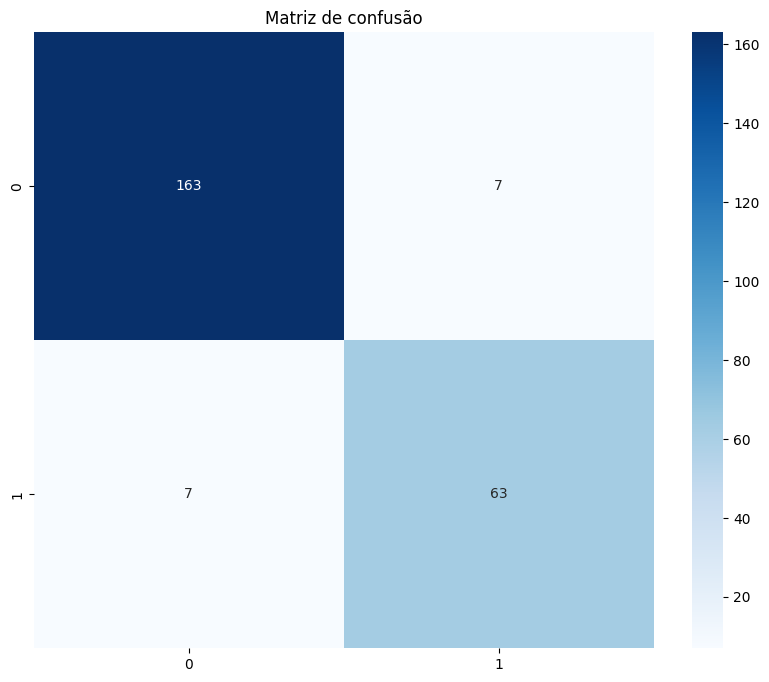

In [ ]:
y_predicted = neuron.predict(x_test)

get_scores(y_test, y_predicted)
get_confusion_matrix(y_test, y_predicted)

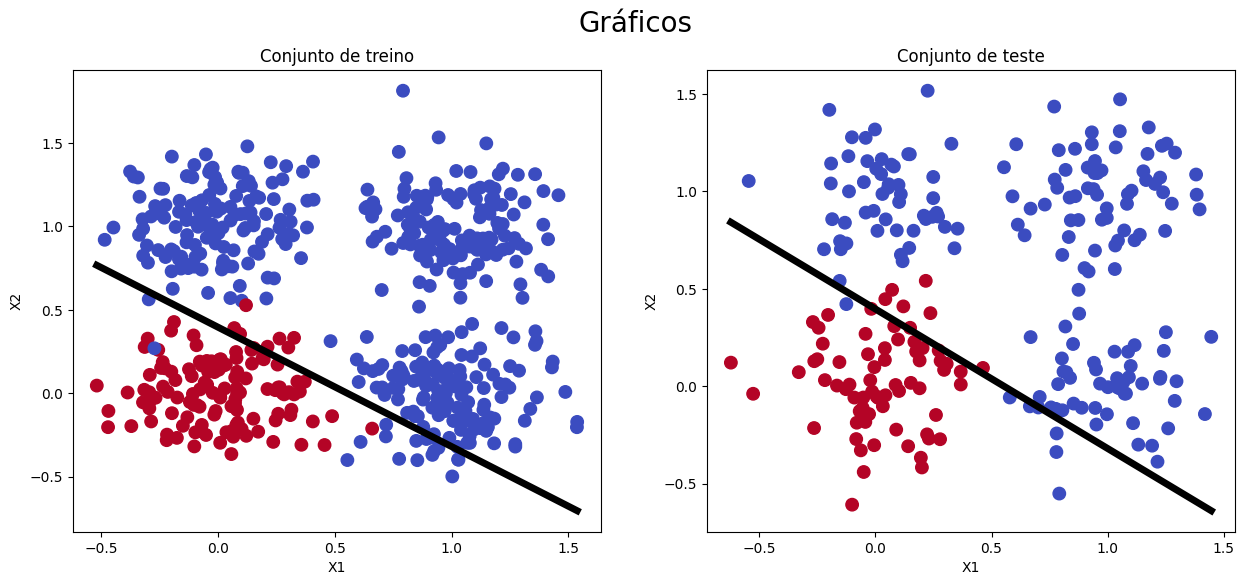

In [ ]:
plot.plot_various(plt, (15, 6), 1, 2, [neuron.weights(), neuron.weights()], [x_train, x_test], [y_train, y_test], ['Conjunto de treino', 'Conjunto de teste'], "Gráficos")

### Conclusão

Apesar da utilização do neurônio não ser ideal para problemas não-linearmente separáveis, a análise dos seus resultados obtidos indica uma solução de alta qualidade, conforme evidenciado pelas métricas calculadas. A seguir, detalhamos cada uma dessas métricas para melhor compreensão da eficácia do modelo.


#### Métricas


##### **Acurácia: 94.17%**

\begin{equation}
  \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN} ≈ 0,94166
\end{equation}

A acurácia representa a proporção de previsões corretas entre todas as previsões realizadas. Uma acurácia de 94.17% indica que o neurônio foi capaz de classificar corretamente a grande maioria dos exemplos no conjunto de testes.

##### **Precisão: 92.94%**

\begin{equation}
  \text{Precisão} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
  \text{Precisão média} = \frac{0.9 + 0.9588}{2} ≈ {0,92941}
\end{equation}

A precisão mede a proporção de verdadeiros positivos entre todos os exemplos classificados como positivos pelo modelo. Com uma precisão de 92.94%, concluímos que o neurônio cometeu poucos erros ao prever exemplos positivos, ou seja, a taxa de falsos positivos é baixa. Este resultado é crucial em aplicações onde é importante minimizar o número de falsos alarmes.

##### **Revocação: 92.94%**

\begin{equation}
  \text{Revocação} = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
  \text{Revocação média} = \frac{0.9 + 0.9588}{2} ≈ {0,92941}
\end{equation}

A revocação indica a capacidade do modelo de identificar corretamente todos os exemplos positivos. Com uma revocação de 92.94%, o neurônio demonstra alta competência em capturar a maioria dos exemplos positivos, minimizando a quantidade de falsos negativos.

##### **F1 Score: 92.94%**

\begin{equation}
  \text{F1} = \frac{2 \times {TP}}{2 \times {TP + FP + FN}}
\end{equation}

\begin{equation}
  \text{F1 Score média} ≈ \frac{0.9 + 0.9588}{2} ≈ {0,92941}
\end{equation}

O F1-Score é a média harmônica entre precisão e revocação, oferecendo um balanço entre essas duas métricas. Um F1-Score de 92.94% confirma que tanto a precisão quanto a revocação estão bem equilibradas, reforçando a robustez do modelo.


